# House prices Time Forecasting

## Importing Libraries

In [184]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import matplotlib

## Reading data

In [185]:
raw_sales = pd.read_csv('Data\house_sales.csv')
raw_sales.head()

,datesold,postcode,price,propertyType,bedrooms
0,2007-02-07 00:00:00,2607,525000,house,4
1,2007-02-27 00:00:00,2906,290000,house,3
2,2007-03-07 00:00:00,2905,328000,house,3
3,2007-03-09 00:00:00,2905,380000,house,4
4,2007-03-21 00:00:00,2906,310000,house,3


## Creating all date features

In [186]:
raw_sales.bedrooms.value_counts()

3    11933
4    10442
2     3598
5     1950
1     1627
0       30
Name: bedrooms, dtype: int64

In [187]:
raw_sales = raw_sales.loc[raw_sales['bedrooms'] != 0]
raw_sales['datesold'] = pd.to_datetime(raw_sales['datesold'])
raw_sales['week'] = raw_sales['datesold'].dt.isocalendar().week
raw_sales['week_day'] = raw_sales['datesold'].dt.weekday
raw_sales['month'] = raw_sales['datesold'].dt.month
raw_sales['season'] = (raw_sales['datesold'].dt.month - 1)//3
raw_sales['year'] = raw_sales['datesold'].dt.year
raw_sales['propertyType']=raw_sales['propertyType'].replace(['house', 'unit'], [0,1])
raw_sales['price_trans'] = np.log(raw_sales.price)
raw_sales.head()

,datesold,postcode,price,propertyType,bedrooms,week,week_day,month,season,year,price_trans
0,2007-02-07,2607,525000,0,4,6,2,2,0,2007,13.171154
1,2007-02-27,2906,290000,0,3,9,1,2,0,2007,12.577636
2,2007-03-07,2905,328000,0,3,10,2,3,0,2007,12.700769
3,2007-03-09,2905,380000,0,4,10,4,3,0,2007,12.847927
4,2007-03-21,2906,310000,0,3,12,2,3,0,2007,12.644328


## Using seasonal decompose to get info about seasonal changes

In [188]:
from statsmodels.tsa.seasonal import seasonal_decompose


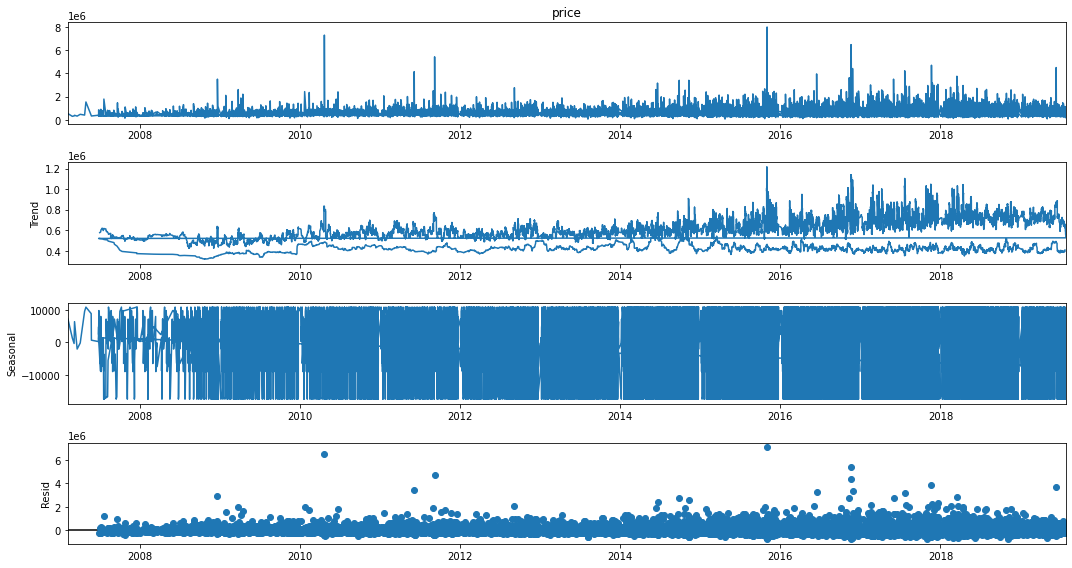

In [189]:
raw_sales.set_index('datesold', inplace =True)
matplotlib.rcParams['figure.figsize'] = [15.0,8.0]
decomposition = seasonal_decompose(raw_sales["price"],model='additive', period = 30)
fig = decomposition.plot()

In [190]:
raw_sales['seasonal'] = decomposition.seasonal
raw_sales['trend'] = decomposition.trend 
raw_sales.dropna(inplace = True)
raw_sales

,postcode,price,propertyType,bedrooms,week,week_day,month,season,year,price_trans,seasonal,trend
datesold,,,,,,,,,,,,
2007-07-02,2914,800000,0,5,27,0,7,2,2007,13.592367,-1112.109818,577166.666667
2007-07-03,2906,336000,0,3,27,1,7,2,2007,12.724866,-6512.351180,578633.333333
2007-07-06,2615,535000,0,5,27,4,7,2,2007,13.190022,-3638.069337,583383.333333
2007-07-07,2602,900000,0,4,27,5,7,2,2007,13.710150,8041.950649,593833.333333
2007-07-08,2600,327000,0,1,27,6,7,2,2007,12.697715,-9041.034784,605008.333333
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-18,2601,580000,1,2,29,3,7,2,2019,13.270783,258.307357,390926.666667
2019-07-19,2911,279000,1,1,29,4,7,2,2019,12.538967,4844.878495,393526.666667
2019-07-23,2617,310000,1,1,30,1,7,2,2019,12.644328,2445.021279,394609.166667


## Looking at price distribution and applying logaritmic transformation to it

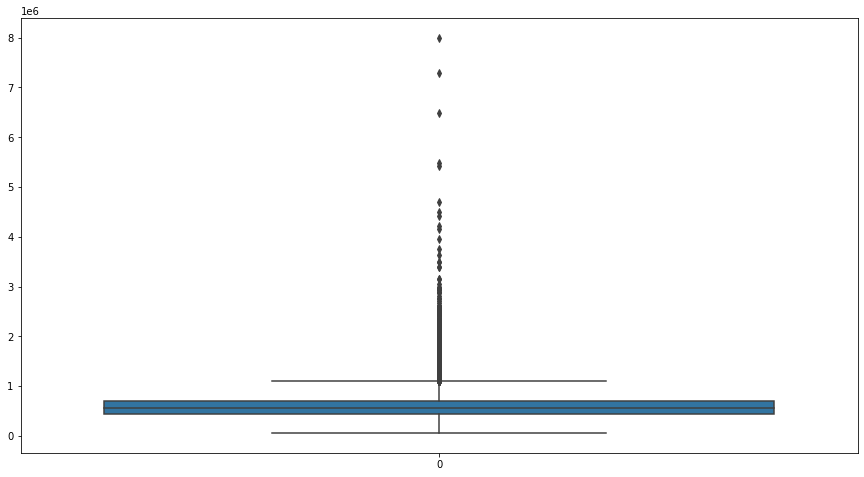

In [191]:
ax = sns.boxplot(raw_sales['price']);

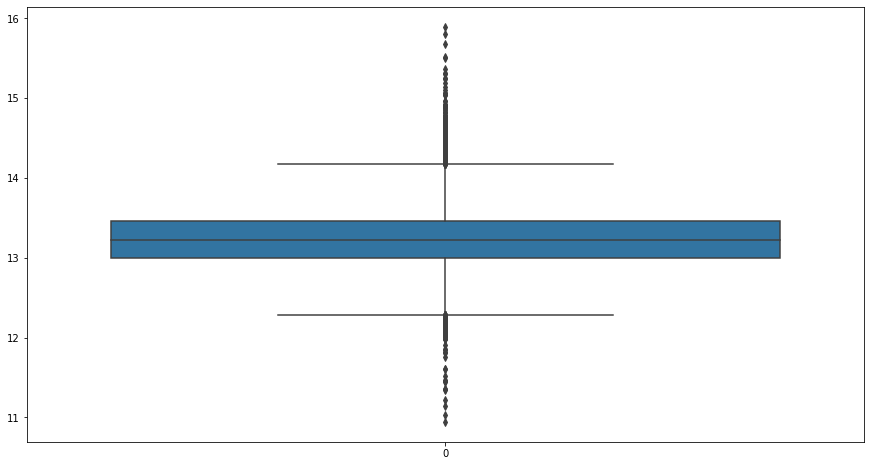

In [192]:
raw_sales['price_trans'] = np.log(raw_sales['price'])

ax = sns.boxplot(raw_sales['price_trans']);

## Separing data in training and testing data

In [193]:
raw_sales.sort_values('datesold', ascending = True, inplace = True)
last_value = int(len(raw_sales) * 0.998)

train_x = raw_sales.iloc[0:last_value].drop(['price', 'price_trans'], axis = 1)
train_y = raw_sales.iloc[0:last_value]['price_trans']
test_x = raw_sales.iloc[last_value:].drop(['price', 'price_trans'], axis = 1)
test_y = raw_sales.iloc[last_value:]['price_trans']

## Creating the model and training

In [194]:
from sklearn.ensemble import GradientBoostingRegressor

params = {'learning_rate': 0.17487160702725146, 'loss': 'absolute_error', 'max_depth': 5, 'min_impurity_decrease': 0.9282174709047137, 'min_samples_leaf': 65, 
          'min_samples_split': 33, 'n_estimators': 50, 'subsample': 0.7067241710796682}

rfr = GradientBoostingRegressor(**params)
rfr.fit(train_x, train_y)

GradientBoostingRegressor(learning_rate=0.17487160702725146,
                          loss='absolute_error', max_depth=5,
                          min_impurity_decrease=0.9282174709047137,
                          min_samples_leaf=65, min_samples_split=33,
                          n_estimators=50, subsample=0.7067241710796682)

## Evaluating the model

In [195]:
test = raw_sales.iloc[last_value:].copy()
test['predictions'] = rfr.predict(test_x)
test['price_prediction'] = np.exp(test['predictions'])
test['error'] = abs(test['price'] - test['price_prediction'])
test['%err'] = abs((test['price_prediction'] / test['price']) - 1)
test.head()

,postcode,price,propertyType,bedrooms,week,week_day,month,season,year,price_trans,seasonal,trend,predictions,price_prediction,error,%err
datesold,,,,,,,,,,,,,,,,
2019-07-18,2606,285000,1,1,29,3,7,2,2019,12.560244,8924.064132,385393.333333,12.579145,290437.764794,5437.764794,0.019080
2019-07-18,2913,881000,0,4,29,3,7,2,2019,13.688813,-2053.315611,662666.666667,13.545092,763060.340003,117939.659997,0.133870
2019-07-18,2607,745000,0,3,29,3,7,2,2019,13.521139,6434.071584,669233.333333,13.469258,707333.678445,37666.321555,0.050559
2019-07-18,2617,702500,0,4,29,3,7,2,2019,13.462401,-332.842203,679433.333333,13.504919,733013.435282,30513.435282,0.043435
2019-07-18,2612,280000,1,1,29,3,7,2,2019,12.542545,10937.852411,386043.333333,12.788380,358032.989442,78032.989442,0.278689


In [196]:
test['%err'].mean()

0.11211991981875283

In [197]:
test.groupby('bedrooms').mean()['%err'].reset_index()

,bedrooms,%err
0,1,0.090436
1,2,0.117900
2,3,0.095950
3,4,0.107603
4,5,0.246993


<AxesSubplot: xlabel='datesold', ylabel='price'>

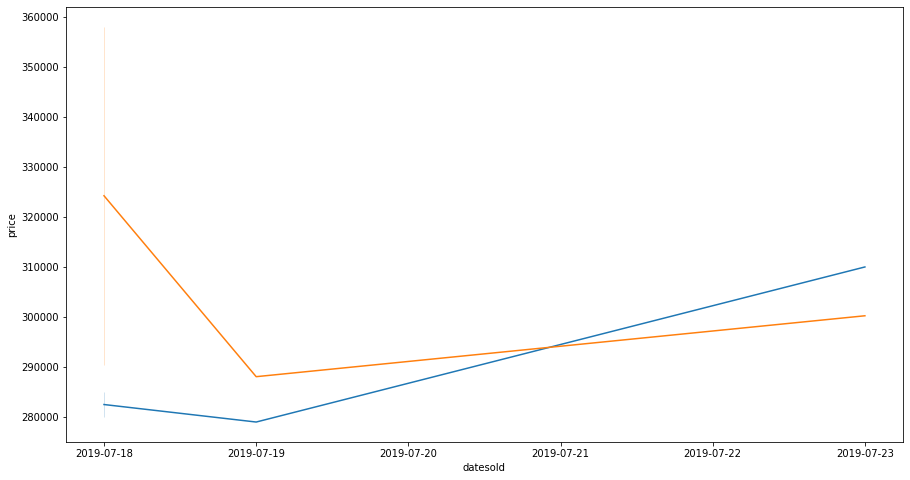

In [198]:
sns.lineplot(x = 'datesold', y = 'price', data = test.loc[test['bedrooms'] == 1])
sns.lineplot(x = 'datesold', y = 'price_prediction', data = test.loc[test['bedrooms'] == 1])
#plt.legend(['Real', 'Predicted'])

<AxesSubplot: xlabel='%err', ylabel='price'>

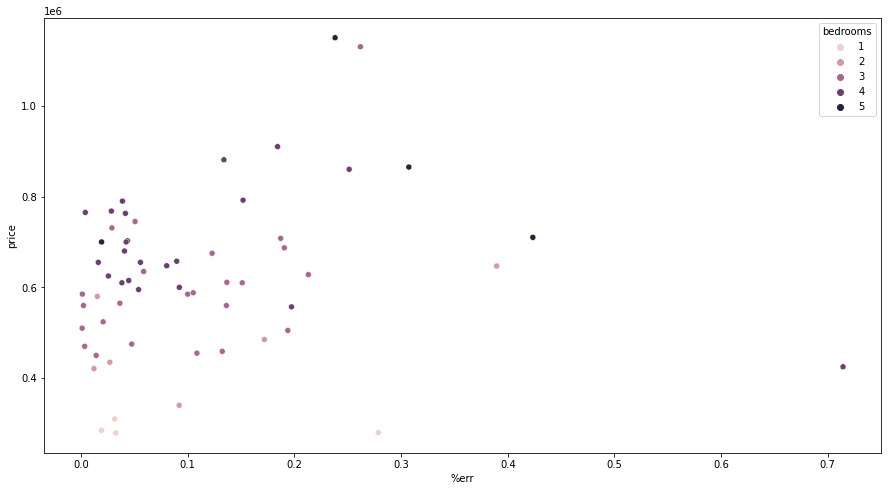

In [199]:
sns.scatterplot(x = '%err', y = 'price', data = test, hue = 'bedrooms')

## Hiperparameter tuning

In [200]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt

In [201]:
parameters = {
        'loss': ['squared_error', 'absolute_error'],
        'learning_rate': sp_randFloat(),
        'subsample'    : sp_randFloat(),
        'n_estimators' : sp_randInt(100, 1000),
        'max_depth'    : sp_randInt(4, 10),
        "n_estimators":[5,50,250,500],
        'min_impurity_decrease': sp_randFloat(),
        'min_samples_leaf': sp_randInt(5,100),
        'min_samples_split': sp_randInt(5,100)
}

In [202]:
randm_src = RandomizedSearchCV(estimator=rfr, param_distributions = parameters,
                               cv = 2, n_iter = 10, n_jobs=-1)
randm_src.fit(train_x, train_y)

print(" Results from Random Search " )
print("\n The best estimator across ALL searched params:\n", randm_src.best_estimator_)
print("\n The best score across ALL searched params:\n", randm_src.best_score_)
print("\n The best parameters across ALL searched params:\n", randm_src.best_params_)

 Results from Random Search 

 The best estimator across ALL searched params:
 GradientBoostingRegressor(learning_rate=0.9369687910065423, max_depth=5,
                          min_impurity_decrease=0.7181731747414732,
                          min_samples_leaf=91, min_samples_split=9,
                          n_estimators=50, subsample=0.9399038273902232)

 The best score across ALL searched params:
 0.6427607659030532

 The best parameters across ALL searched params:
 {'learning_rate': 0.9369687910065423, 'loss': 'squared_error', 'max_depth': 5, 'min_impurity_decrease': 0.7181731747414732, 'min_samples_leaf': 91, 'min_samples_split': 9, 'n_estimators': 50, 'subsample': 0.9399038273902232}


In [203]:
randm_src.best_estimator_.score(test_x, test_y)

0.6570856852128106

## Making point-wise predictions

In [204]:
test_x.iloc[-2]

postcode               2615.0
propertyType              0.0
bedrooms                  4.0
week                     30.0
week_day                  5.0
month                     7.0
season                    2.0
year                   2019.0
seasonal          -140.327806
trend           538166.666667
Name: 2019-07-27 00:00:00, dtype: Float64

In [205]:
np.exp(test_y.iloc[-1])

865000.0000000002

In [206]:
np.exp(rfr.predict(np.array([[2905,0,5,30,5,7,2,2019,-140.32,538166.67]])))

d:\Anaconda\envs\teste\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


array([645049.03894348])